In [1]:
!pip install split-folders
!pip install gdown

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import gdown
import splitfolders
import shutil
from tensorflow.keras.applications import ResNet152
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files

In [3]:
shutil.rmtree("SkinDisease", ignore_errors=True)
shutil.rmtree("skin_dataset", ignore_errors=True)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_id = "1NZTookxlFKAU371O3SW4KG41doDAKZej"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="dataset.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1NZTookxlFKAU371O3SW4KG41doDAKZej
From (redirected): https://drive.google.com/uc?id=1NZTookxlFKAU371O3SW4KG41doDAKZej&confirm=t&uuid=133fd3ad-753d-4163-9ddd-8612ba2aee74
To: /content/dataset.zip
100%|██████████| 2.14G/2.14G [00:30<00:00, 71.1MB/s]


'dataset.zip'

In [6]:
!unzip -q dataset.zip -d skin_dataset

In [7]:
splitfolders.ratio(
    input="skin_dataset",           # Folder hasil unzip
    output="SkinDisease",           # Folder output untuk split
    seed=42,
    ratio=(0.7, 0.3),               # 70% train, 30% test
    move=False                      # Copy, bukan pindah file
)
os.rename("SkinDisease/val", "SkinDisease/test")

Copying files: 37293 files [00:15, 2437.54 files/s]


In [8]:
train_dir = "SkinDisease/train"
test_dir = "SkinDisease/test"

In [9]:
def count_images_per_split(split_path):
    total = 0
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            count = len(os.listdir(cls_path))
            print(f"{cls}: {count}")
            total += count
    print(f"Total: {total}")

print("=== TRAIN ===")
count_images_per_split("SkinDisease/train")
print("\n=== TEST ===")
count_images_per_split("SkinDisease/test")

=== TRAIN ===
Lupus: 1202
Lichen: 1234
Vitiligo: 1250
Sun_Sunlight_Damage: 1210
Benign_tumors: 1274
Candidiasis: 1205
Actinic_Keratosis: 1253
Moles: 1222
Vasculitis: 1241
Psoriasis: 1253
Warts: 1247
Vascular_Tumors: 1233
Rosacea: 1220
Acne: 1288
Seborrh_Keratoses: 1225
SkinCancer: 1248
Tinea: 1273
DrugEruption: 1284
Infestations_Bites: 1229
Eczema: 1273
Bullous: 1232
Total: 26096

=== TEST ===
Lupus: 516
Lichen: 530
Vitiligo: 536
Sun_Sunlight_Damage: 519
Benign_tumors: 547
Candidiasis: 517
Actinic_Keratosis: 537
Moles: 524
Vasculitis: 533
Psoriasis: 538
Warts: 535
Vascular_Tumors: 529
Rosacea: 524
Acne: 552
Seborrh_Keratoses: 526
SkinCancer: 535
Tinea: 546
DrugEruption: 551
Infestations_Bites: 528
Eczema: 546
Bullous: 528
Total: 11197


In [10]:
classes = [
    "Acne", "Actinic Keratosis", "Benign Tumors", "Bullous", "Candidiasis",
    "Drug Eruption", "Eczema", "Infestations/Bites", "Lichen", "Lupus",
    "Moles", "Psoriasis", "Rosacea", "Seborrheic Keratoses", "Skin Cancer",
    "Sun/Sunlight Damage", "Tinea", "Vascular Tumors", "Vasculitis", "Vitiligo",
    "Warts"
]

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

In [12]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 20886 images belonging to 21 classes.
Found 5210 images belonging to 21 classes.
Found 11197 images belonging to 21 classes.


In [13]:
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {val_generator.samples}")
print(f"Number of testing samples: {test_generator.samples}")

Number of training samples: 20886
Number of validation samples: 5210
Number of testing samples: 11197


In [14]:
def show_images(generator, classes, num_images=8):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title(classes[np.argmax(labels[i])])
        axes[i].axis('off')
    plt.show()

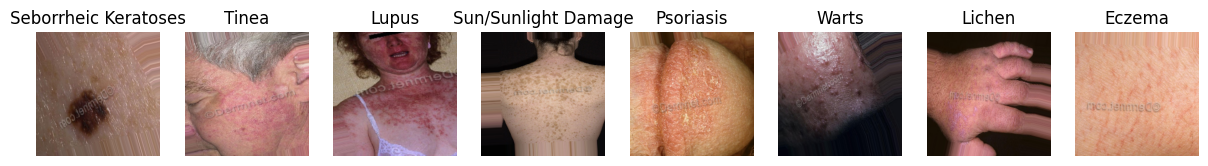

In [15]:
show_images(train_generator, classes)

In [16]:
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = True
# from tensorflow.keras.applications import EfficientNetB1
# base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = True

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(train_generator.num_classes, activation='softmax')(x)

In [18]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    verbose=1,
    restore_best_weights=True,
    #baseline=0.90
)

callbacks = [reduce_lr, checkpoint, early_stopping]

In [19]:
model = models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 58,900,885 (224.69 MB)

 Trainable params: 58,749,461 (224.11 MB)

 Non-trainable params: 151,424 (591.50 KB)

In [21]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.6417 - loss: 1.2806
Epoch 1: val_accuracy improved from -inf to 0.06545, saving model to best_model.h5


653/653 ━━━━━━━━━━━━━━━━━━━━ 804s 957ms/step - accuracy: 0.6418 - loss: 1.2801 - val_accuracy: 0.0655 - val_loss: 3.1633 - learning_rate: 1.0000e-04
Epoch 2/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.7765 - loss: 0.7588
Epoch 2: val_accuracy improved from 0.06545 to 0.73992, saving model to best_model.h5


653/653 ━━━━━━━━━━━━━━━━━━━━ 557s 852ms/step - accuracy: 0.7766 - loss: 0.7588 - val_accuracy: 0.7399 - val_loss: 0.9503 - learning_rate: 1.0000e-04
Epoch 3/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.8106 - loss: 0.6364
Epoch 3: val_accuracy improved from 0.73992 to 0.75528, saving model to best_model.h5


653/653 ━━━━━━━━━━━━━━━━━━━━ 530s 812ms/step - accuracy: 0.8106 - loss: 0.6364 - val_accuracy: 0.7553 - val_loss: 0.9895 - learning_rate: 1.0000e-04
Epoch 4/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - accuracy: 0.8329 - loss: 0.5536
Epoch 4: val_accuracy improved from 0.75528 to 0.76507, saving model to best_model.h5


653/653 ━━━━━━━━━━━━━━━━━━━━ 532s 813ms/step - accuracy: 0.8329 - loss: 0.5536 - val_accuracy: 0.7651 - val_loss: 1.0473 - learning_rate: 1.0000e-04
Epoch 5/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.8537 - loss: 0.4901
Epoch 5: val_accuracy improved from 0.76507 to 0.77812, saving model to best_model.h5


653/653 ━━━━━━━━━━━━━━━━━━━━ 522s 798ms/step - accuracy: 0.8537 - loss: 0.4901 - val_accuracy: 0.7781 - val_loss: 0.9269 - learning_rate: 1.0000e-04
Epoch 6/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.8733 - loss: 0.4136
Epoch 6: val_accuracy did not improve from 0.77812
653/653 ━━━━━━━━━━━━━━━━━━━━ 504s 771ms/step - accuracy: 0.8733 - loss: 0.4137 - val_accuracy: 0.7724 - val_loss: 0.9541 - learning_rate: 1.0000e-04
Epoch 7/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.8743 - loss: 0.4058
Epoch 7: val_accuracy did not improve from 0.77812
653/653 ━━━━━━━━━━━━━━━━━━━━ 502s 769ms/step - accuracy: 0.8743 - loss: 0.4058 - val_accuracy: 0.7779 - val_loss: 0.9723 - learning_rate: 1.0000e-04
Epoch 8/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.8923 - loss: 0.3617
Epoch 8: val_accuracy improved from 0.77812 to 0.79328, saving model to best_model.h5


653/653 ━━━━━━━━━━━━━━━━━━━━ 516s 790ms/step - accuracy: 0.8923 - loss: 0.3617 - val_accuracy: 0.7933 - val_loss: 0.8979 - learning_rate: 1.0000e-04
Epoch 9/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accuracy: 0.9083 - loss: 0.3088
Epoch 9: val_accuracy did not improve from 0.79328
653/653 ━━━━━━━━━━━━━━━━━━━━ 509s 778ms/step - accuracy: 0.9083 - loss: 0.3088 - val_accuracy: 0.7739 - val_loss: 1.1317 - learning_rate: 1.0000e-04
Epoch 10/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.9153 - loss: 0.2676
Epoch 10: val_accuracy did not improve from 0.79328
653/653 ━━━━━━━━━━━━━━━━━━━━ 510s 780ms/step - accuracy: 0.9153 - loss: 0.2676 - val_accuracy: 0.7693 - val_loss: 1.2281 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 8.


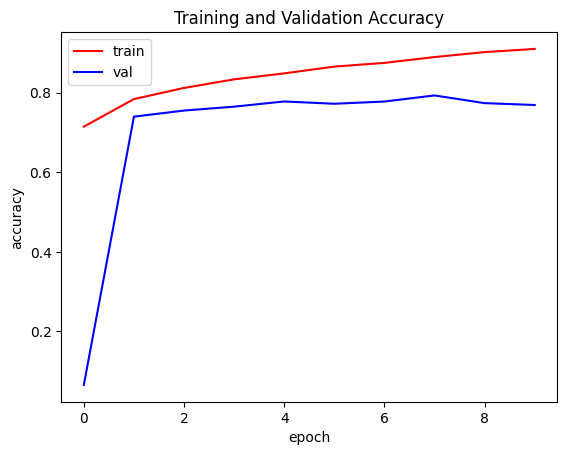

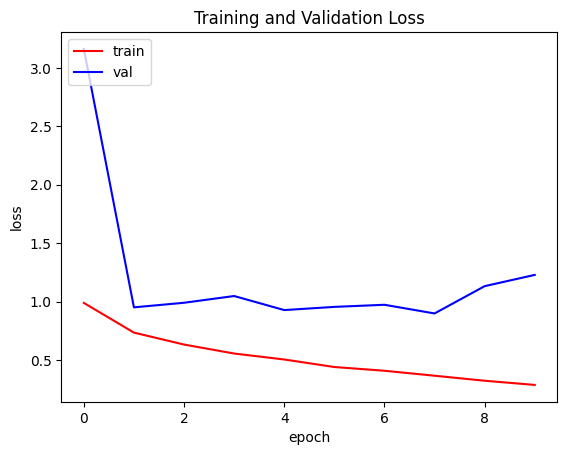

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
model.save("resnet_model.h5")
print("Model saved as resnet_model.h5")

Model saved as resnet_model.h5


In [24]:
model.save("model1.h5", include_optimizer=False)

In [25]:
# Path folder di Google Drive
save_path = '/content/drive/My Drive/best_model1.h5'

# Simpan model ke Google Drive
model.save(save_path, include_optimizer=False)
print(f"Model saved to {save_path}")

Model saved to /content/drive/My Drive/best_model1.h5


In [26]:
model = tf.keras.models.load_model("best_model.h5")
print("Model loaded successfully")

Model loaded successfully


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


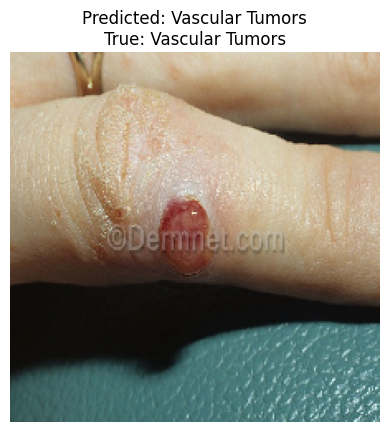

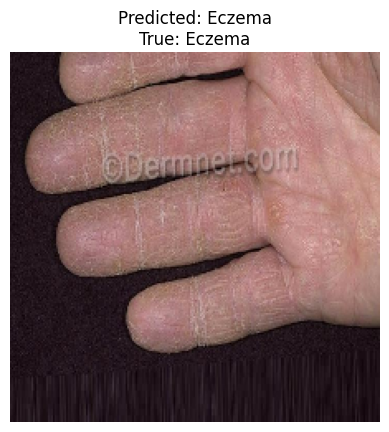

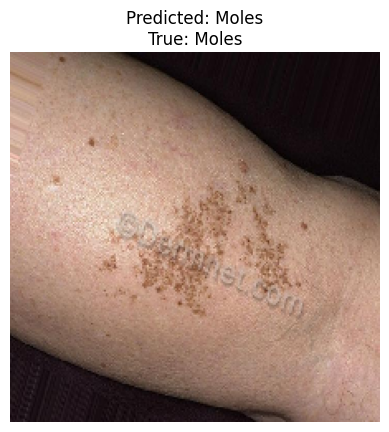

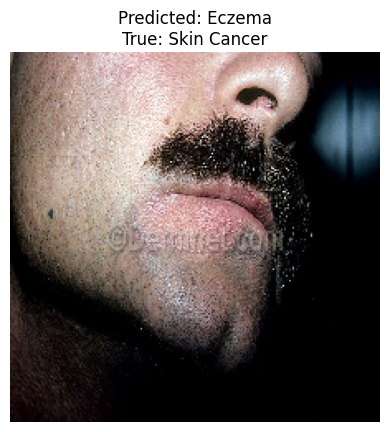

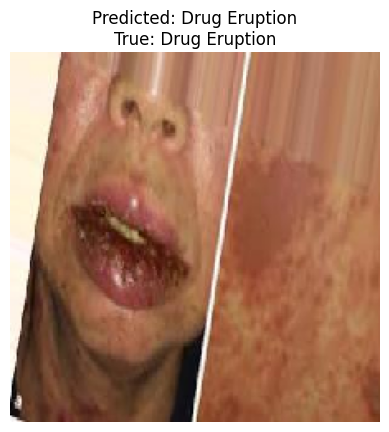

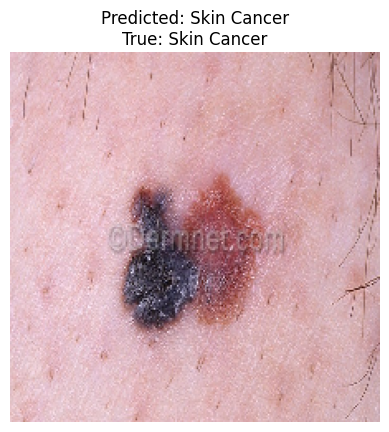

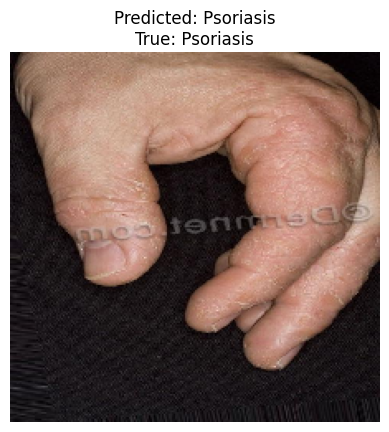

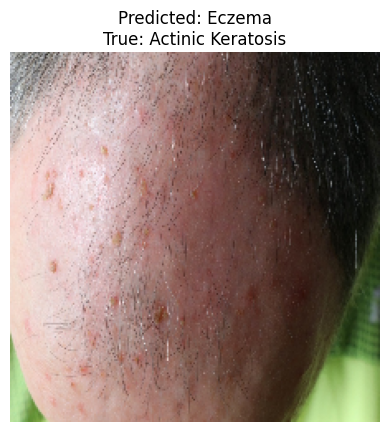

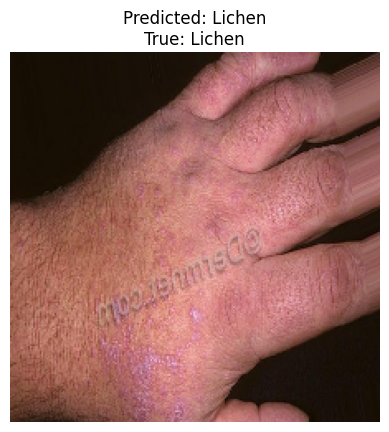

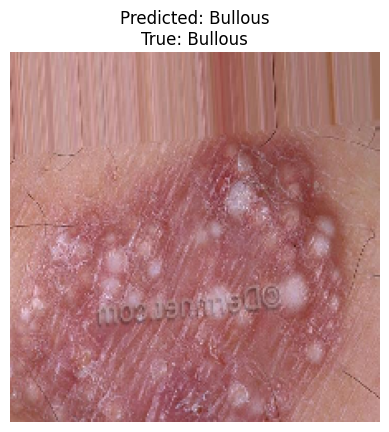

In [27]:
def predict_and_show(model, generator, class_names, num_images=5):
    images, labels = next(generator)
    predictions = model.predict(images[:num_images])
    for i in range(num_images):
        plt.imshow(images[i])
        plt.title(f"Predicted: {class_names[np.argmax(predictions[i])]}\nTrue: {class_names[np.argmax(labels[i])]}" )
        plt.axis('off')
        plt.show()

predict_and_show(model, test_generator, classes, num_images=10)

In [28]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Accuracy on the test set: {test_accuracy * 100:.2f}%")

350/350 ━━━━━━━━━━━━━━━━━━━━ 93s 230ms/step - accuracy: 0.8148 - loss: 0.6998
Accuracy on the test set: 81.28%


In [29]:
test_generator.reset()
preds = model.predict(test_generator, verbose=0)
preds = np.argmax(preds, axis=1)

cm = confusion_matrix(test_generator.classes, preds)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(
    y_true=test_generator.classes,
    y_pred=preds,
    target_names=classes,
    digits=4
))

Confusion Matrix:
[[25 32 38 23 23 39 25 17 20 26 21 23 31 20 36 15 29 25 34 26 24]
 [25 36 31 21 29 25 33 22 21 24 25 28 28 15 19 23 29 20 35 27 21]
 [27 35 33 26 23 35 27 22 26 18 27 34 25 24 23 22 33 22 27 21 17]
 [17 35 42 23 23 33 26 21 16 18 16 22 22 23 27 22 33 32 40 21 16]
 [25 23 33 31 23 36 27 22 17 11 22 27 28 22 23 14 29 21 37 27 19]
 [25 23 32 27 23 39 29 18 29 20 21 17 21 20 29 36 28 20 37 35 22]
 [15 27 39 24 17 27 32 30 26 20 26 32 22 19 29 22 29 35 36 29 10]
 [19 22 46 28 20 29 17 26 22 19 26 25 26 16 33 19 34 20 28 27 26]
 [21 25 31 25 22 33 32 23 15 17 27 29 21 23 37 13 35 21 33 26 21]
 [27 20 36 19 21 42 20 19 23 18 19 24 30 23 32 23 28 26 26 18 22]
 [17 18 35 19 22 29 35 34 18 23 25 25 22 25 28 20 30 23 31 27 18]
 [25 32 27 21 23 36 28 20 28 29 24 30 16 22 26 14 26 25 37 29 20]
 [24 16 31 23 23 24 33 26 19 18 23 30 29 20 27 21 33 25 31 24 24]
 [18 27 33 19 28 30 18 26 15 26 22 38 32 19 18 21 30 22 31 36 17]
 [19 26 35 29 24 30 27 25 20 21 23 26 26 20 26 26 24 28 34